In [8]:
import pandas as pd

from src.constant import MAIN_DIR
from src.database import DB
from tqdm.auto import tqdm
import numpy as np

PHASE2_DIR = MAIN_DIR / "archive" / "phase2"

In [9]:
records = []
db_path_list = list(PHASE2_DIR.glob("run-policy-*.db"))
progress_bar = tqdm(total=len(db_path_list), desc="Processing")

for db_path in db_path_list:
    parts = db_path.stem.split("-")
    policy, parg, n_train = parts[2:5]
    progress_bar.set_description(f"{policy=}, {parg=}, {n_train=}") 

    db = DB(db_path)
    results = db.get_results()
    results_test = results.loc[results["prefix"].str.startswith("test")]
    # if results_test.shape[0] != 2500:
    if results_test.empty:
        print(f"No results {db_path}")
        continue
    cost = (
        results.loc[results["prefix"].str.startswith("test")]
        .groupby(["instance_id", "prefix"])["cost"]
        .min()  # min for every problem (of 2 solvers)
        .reset_index()
        .groupby("instance_id")["cost"]
        .median()  # median over 5 runs
    )
    if cost.max() >= 100:
        print(f"Test cut-off {db_path}")
    cost = cost.mean()  # total mean score
    cpu_time = (
        results.loc[
            results["prefix"].str.startswith("config")
            & results["cached"].eq(0)
            & results["surrogate"].eq(0),
            "time",
        ].sum()
        / 3600
    )
    surrogate_pct = results.loc[results["prefix"].str.startswith("config")].groupby(["solver_id", "instance_id"])["surrogate"].max().mean()
    real_pct = results.loc[results["prefix"].str.startswith("config")].groupby(["solver_id", "instance_id"])["surrogate"].min().eq(0).mean()
    records.append(
        {
            "db_path": db_path.parts[-1],
            "n_train": n_train,
            "policy": policy,
            "parg": parg,
            "cost": cost,
            "cpu_time": cpu_time,
            "surrogate_pct": surrogate_pct,
            "real_pct": real_pct,
        }
    )
    progress_bar.update(1)
progress_bar.close()

df = pd.DataFrame(records)
df

Processing:   0%|          | 0/310 [00:00<?, ?it/s]

,db_path,n_train,policy,parg,cost,cpu_time,surrogate_pct,real_pct
0,run-policy-baseline--100-1016233.db,100,baseline,,0.10736,14.748363,0.00000,1.000000
1,run-policy-baseline--100-1016239.db,100,baseline,,0.11484,14.685052,0.00000,1.000000
2,run-policy-baseline--100-1016307.db,100,baseline,,0.16572,13.298055,0.00000,1.000000
3,run-policy-baseline--100-1016313.db,100,baseline,,0.08056,13.397742,0.00000,1.000000
4,run-policy-baseline--100-1016319.db,100,baseline,,0.18088,11.804989,0.00000,1.000000
...,...,...,...,...,...,...,...,...
305,run-policy-ib--25-1015015.db,25,ib,,0.24844,0.723468,0.97449,0.219388
306,run-policy-ib--25-1015021.db,25,ib,,0.13472,0.431243,0.97449,0.142857
307,run-policy-ib--25-1015027.db,25,ib,,0.19264,0.541641,0.97449,0.142857
308,run-policy-ib--25-1015033.db,25,ib,,0.20272,0.600577,0.97449,0.142857


In [10]:
df.pivot_table(index=["policy", "parg"], columns="n_train", values="cpu_time", aggfunc="count")

n_train        100    25
policy   parg           
baseline       5.0  20.0
ea       25    NaN  20.0
         50    6.0  20.0
         75    NaN  20.0
eb       25    NaN  20.0
         50    6.0  20.0
         75    NaN  20.0
ec       100   2.0  20.0
         50    NaN  20.0
         75    NaN  20.0
ia       1+1   5.0  20.0
         1+2   NaN  20.0
         2+1   NaN  20.0
ib             6.0  20.0

In [6]:
IDX = [
    ("baseline", ""),
    ("ea", "25"),
    ("ea", "50"),
    ("ea", "75"),
    ("eb", "75"),
    ("eb", "50"),
    ("eb", "25"),
    ("ec", "100"),
    ("ec", "75"),
    ("ec", "50"),
    ("ia", "1+2"),
    ("ia", "1+1"),
    ("ia", "2+1"),
    ("ib", ""),
]

def agg(x):
    df_agg = x.groupby(["policy", "parg"]).agg(
        cost=("cost", "mean"),
        cpu_time=("cpu_time", "mean"),
        surrogate_pct=("surrogate_pct", "mean"),
        real_pct=("real_pct", "mean"),
    )
    baseline_cost = df_agg.at[("baseline", ""), "cost"]
    baseline_cpu_time = df_agg.at[("baseline", ""), "cpu_time"]
    df_agg["cost_ratio_to_baseline"] = df_agg["cost"] / baseline_cost
    df_agg["cpu_time_ratio_to_baseline"] = df_agg["cpu_time"] / baseline_cpu_time
    df_agg["alpha"] = baseline_cost / df_agg["cost"]
    df_agg["beta"] = (baseline_cpu_time - df_agg["cpu_time"]) * 3600 / df_agg["cost"]
    df_agg["better_than_baseline_until"] = np.floor(df_agg["beta"] / (1 - df_agg["alpha"])) + 1
    df_agg.loc[df_agg["beta"] < 0, "better_than_baseline_until"] = np.nan

    df_agg = df_agg.round(4)
    df_agg = df_agg.loc[IDX, ["cost", "cost_ratio_to_baseline", "cpu_time", "cpu_time_ratio_to_baseline", "surrogate_pct", "real_pct", "alpha", "beta", "better_than_baseline_until"]]
    return df_agg

df25 = df.loc[df["n_train"] == "25"].copy()
df100 = df.loc[df["n_train"] == "100"].copy()

df25_agg = agg(df25)
# df100_agg = agg(df100)

df25_agg

cost  cost_ratio_to_baseline  cpu_time  \
policy   parg                                             
baseline       0.1704                  1.0000    3.4364   
ea       25    0.1777                  1.0429    2.6212   
         50    0.1892                  1.1102    1.8178   
         75    0.2100                  1.2322    0.9898   
eb       75    0.2076                  1.2186    1.7709   
         50    0.2523                  1.4808    0.7321   
         25    0.2654                  1.5576    0.2356   
ec       100   0.1605                  0.9420    7.9756   
         75    0.1688                  0.9907    5.2202   
         50    0.1810                  1.0621    4.3055   
ia       1+2   0.1890                  1.1091    2.3284   
         1+1   0.2098                  1.2309    1.7811   
         2+1   0.2422                  1.4214    1.2420   
ib             0.2460                  1.4434    0.5251   

               cpu_time_ratio_to_baseline  surrogate_pct  real_pct   alpha  \
policy   parg                                                                
baseline                           1.0000         0.0000    1.0000  1.0000   
ea       25                        0.7628         0.2443    0.7578  0.9589   
         50                        0.5290         0.4876    0.5172  0.9007   
         75                        0.2880         0.7308    0.2765  0.8116   
eb       75                        0.5153         0.9745    0.7684  0.8206   
         50                        0.2131         0.9745    0.5364  0.6753   
         25                        0.0686         0.9745    0.3052  0.6420   
ec       100                       2.3209         0.9745    1.0000  1.0616   
         75                        1.5191         0.9745    1.0000  1.0094   
         50                        1.2529         0.9745    1.0000  0.9416   
ia       1+2                       0.6776         0.3265    0.6758  0.9016   
         1+1                       0.5183         0.4898    0.5122  0.8124   
         2+1                       0.3614         0.6531    0.3508  0.7035   
ib                                 0.1528         0.9745    0.1543  0.6928   

                      beta  better_than_baseline_until  
policy   parg                                           
baseline            0.0000                         NaN  
ea       25     16513.8368                    401360.0  
         50     30800.9589                    310187.0  
         75     41948.2775                    222611.0  
eb       75     28875.2962                    160981.0  
         50     38581.1913                    118821.0  
         25     43414.9379                    121279.0  
ec       100  -101806.9231                         NaN  
         75    -38040.6372                         NaN  
         50    -17288.2736                         NaN  
ia       1+2    21105.6129                    214567.0  
         1+1    28409.4773                    151429.0  
         2+1    32616.5919                    110019.0  
ib              42611.9532                    138713.0

In [ ]:
# df25_agg.to_excel("tmp.xlsx")

In [19]:
df.loc[(df["policy"] == "ib")] # & (df["parg"] == "100") & (df["n_train"] == "100")].sort_values(by="cost")

,db_path,n_train,policy,parg,cost,cpu_time,surrogate_pct,real_pct
268,run-policy-ib--100-1016238.db,100,ib,,0.12692,1.510313,0.97449,0.132653
269,run-policy-ib--100-1016244.db,100,ib,,0.10700,3.001511,0.97449,0.234694
270,run-policy-ib--25-1014188.db,25,ib,,0.17224,0.380440,0.97449,0.127551
271,run-policy-ib--25-1014195.db,25,ib,,0.26812,0.859516,0.97449,0.209184
272,run-policy-ib--25-1014201.db,25,ib,,0.29032,0.652372,0.97449,0.188776
273,run-policy-ib--25-1014207.db,25,ib,,0.31284,0.268974,0.97449,0.091837
274,run-policy-ib--25-1014213.db,25,ib,,0.23328,0.688468,0.97449,0.193878
275,run-policy-ib--25-1014219.db,25,ib,,0.20044,0.507706,0.97449,0.173469
276,run-policy-ib--25-1014225.db,25,ib,,0.35324,0.467037,0.97449,0.168367
277,run-policy-ib--25-1014231.db,25,ib,,0.49188,0.485386,0.97449,0.147959


In [20]:
# db = DB(PHASE2_DIR / "run-policy-ib--100-1016238.db")

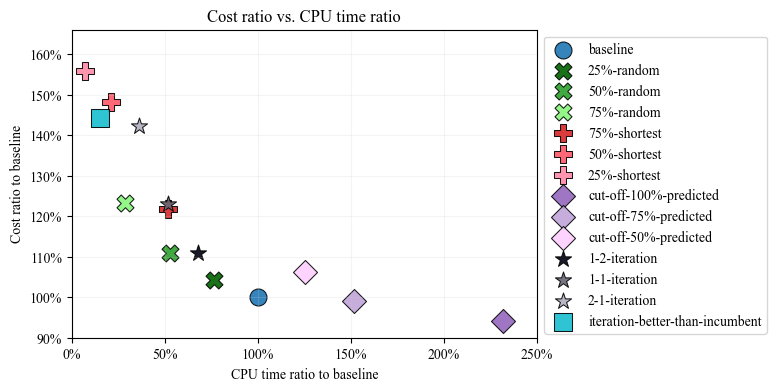

In [30]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.2
plt.rcParams["grid.color"] = "#cccccc"
plt.rcParams["axes.xmargin"] = 0
fig, ax = plt.subplots(figsize=(6, 4))

COLORS = {
    ("baseline", ""): "#1f77b4",
    ("ea", "25"): "#006300",
    ("ea", "50"): "#2ca02c",
    ("ea", "75"): "#89f57b",
    ("eb", "75"): "#d62728",
    ("eb", "50"): "#ff5968",
    ("eb", "25"): "#ff8aa7",
    ("ec", "100"): "#9467bd",
    ("ec", "75"): "#c1a4d8",
    ("ec", "50"): "#ffcfff",
    ("ia", "1+2"): "#010013", 
    ("ia", "1+1"): "#696676",
    ("ia", "2+1"): "#b1afc0",
    ("ib", ""): "#17becf",
}

LABELS = {
    ("baseline", ""): "baseline",
    ("ea", "25"): "25%-random",
    ("ea", "50"): "50%-random",
    ("ea", "75"): "75%-random",
    ("eb", "75"): "75%-shortest",
    ("eb", "50"): "50%-shortest",
    ("eb", "25"): "25%-shortest",
    ("ec", "100"): "cut-off-100%-predicted",
    ("ec", "75"): "cut-off-75%-predicted",
    ("ec", "50"): "cut-off-50%-predicted",
    ("ia", "1+2"): "1-2-iteration", 
    ("ia", "1+1"): "1-1-iteration",
    ("ia", "2+1"): "2-1-iteration",
    ("ib", ""): "iteration-better-than-incumbent",
}

MARKERS = {
    "baseline": "o",
    "ea": "X",
    "eb": "P",
    "ec": "D",
    "ia": "*",
    "ib": "s",
}
BASELINE_COST = df25_agg.at[("baseline", ""), "cost"]
BASELINE_CPU_TIME = df25_agg.at[("baseline", ""), "cpu_time"]

for (policy, parg), row in df25_agg.iterrows():
    # _ = df.loc[(df["policy"] == policy) & (df["parg"] == parg) & (df["n_train"] == "25")]
    # plt.scatter(
    #     _["cpu_time"] / BASELINE_CPU_TIME,
    #     _["cost"] / BASELINE_COST,
    #     s=20,
    #     alpha=0.9,
    #     color=COLORS[(policy, parg)],
    #     marker=MARKERS[policy],
    #     linewidths=0.5,
    #     edgecolor="black",
    # )
    plt.scatter(
        row["cpu_time_ratio_to_baseline"],
        row["cost_ratio_to_baseline"],
        s=150,
        alpha=0.9,
        color=COLORS[(policy, parg)],
        marker=MARKERS[policy],
        linewidths=0.75,
        edgecolor="black",
        label=LABELS[(policy, parg)],
    )

ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))

plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.xlabel("CPU time ratio to baseline")
plt.ylabel("Cost ratio to baseline")
plt.xlim(0, 2.5)
# plt.xlim(0, 1)
plt.ylim(0.9, 1.66)
plt.title("Cost ratio vs. CPU time ratio")
# plt.savefig("fig.png", dpi=300, bbox_inches="tight")
plt.show()

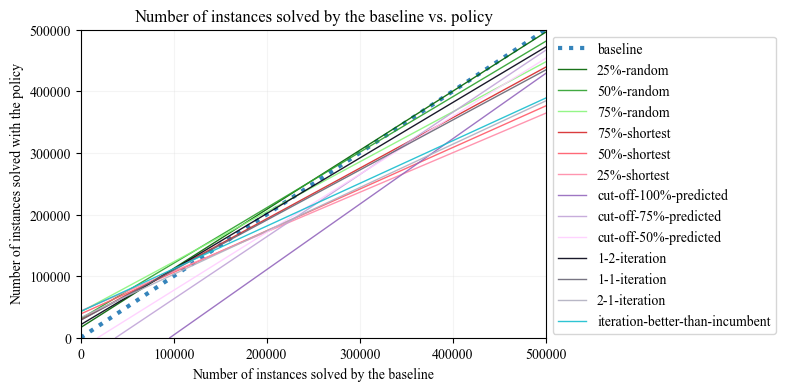

In [42]:
fig, ax = plt.subplots(figsize=(6, 4))

for (policy, parg), row in df25_agg.iterrows():
    cost = row["cost"]
    cpu_time = row["cpu_time"]
    alpha = BASELINE_COST / cost
    beta = (BASELINE_CPU_TIME - cpu_time) * 3600 / cost
    ax.axline(
        (0, row["beta"]),
        slope=row["alpha"],
        alpha=0.9,
        color=COLORS[(policy, parg)],
        lw=1 if policy != "baseline" else 3,
        ls="-" if policy != "baseline" else "dotted",
        label=LABELS[(policy, parg)],
    )

plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.xlabel("Number of instances solved by the baseline")
plt.ylabel("Number of instances solved with the policy")
plt.xlim(0, 500000)
plt.ylim(0, 500000)
plt.title("Number of instances solved by the baseline vs. policy")
# plt.savefig("fig.png", dpi=300, bbox_inches="tight")
plt.show()